<a href="https://colab.research.google.com/github/fazalpge/yolox_custom_training/blob/main/ArUco_marker_detection_and_object_distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-contrib-python

Detected 3 ArUco markers


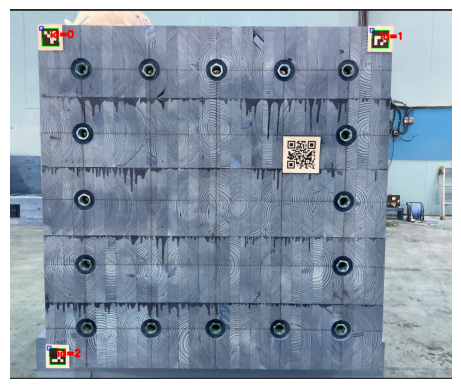

Saved image with ArUco markers to: /content/drive/MyDrive/Colab Notebooks/yolox/YOLOX/YOLOX_outputs/test_with_aruco.jpg


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to detect ArUco markers
def detect_aruco_markers(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    aruco_params = cv2.aruco.DetectorParameters()
    corners, ids, rejected = cv2.aruco.detectMarkers(gray, aruco_dict, parameters=aruco_params)

    if ids is not None:
        print(f"Detected {len(ids)} ArUco markers")
    else:
        print("No ArUco markers detected")

    return corners, ids

# Load the image
image_path = '/content/drive/MyDrive/Colab Notebooks/yolox/YOLOX/assets/board2.jpg'
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not loaded properly. Check the file path.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect ArUco markers
corners, ids = detect_aruco_markers(image)
image_with_aruco = image.copy()



# Draw markers if detected
if ids is not None:
    image_with_aruco = cv2.aruco.drawDetectedMarkers(image_with_aruco, corners, ids)

# Display the image with ArUco markers
plt.imshow(image_with_aruco)
plt.axis('off')
plt.show()

# Convert to RGB for Matplotlib display
image_with_aruco_rgb = cv2.cvtColor(image_with_aruco, cv2.COLOR_BGR2RGB)

# Save the image with ArUco markers
output_path = '/content/drive/MyDrive/Colab Notebooks/yolox/YOLOX/YOLOX_outputs/test_with_aruco.jpg'
cv2.imwrite(output_path, image_with_aruco_rgb)

print(f"Saved image with ArUco markers to: {output_path}")


In [7]:
%cd /content/drive/MyDrive/Colab Notebooks/yolox
!pip install loguru
!pip install torch torchvision

/content/drive/MyDrive/Colab Notebooks/yolox


In [8]:
%cd /content/drive/MyDrive/Colab Notebooks/yolox
!git clone https://github.com/Megvii-BaseDetection/YOLOX.git
%cd YOLOX
!pip install -v -e .

/content/drive/MyDrive/Colab Notebooks/yolox
fatal: destination path 'YOLOX' already exists and is not an empty directory.
/content/drive/MyDrive/Colab Notebooks/yolox/YOLOX
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/yolox/YOLOX
  Running command python setup.py egg_info
  /usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!

          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************

  !!
    dist.fetch_build_eggs(dist.setup_requires)
  running egg_info
  creating /tmp/pip-pip-egg-info-fahh3d5p/yolox.egg-info
  writing /tmp/pip-pip-egg-i

In [9]:
# In your custom YOLOX config file (e.g., yolox_s.py)
num_classes = 2  # Set this to the number of classes in your custom dataset

# Update the model configuration
from yolox.models import YOLOX, YOLOPAFPN, YOLOXHead

def get_model():
    depth = 0.33
    width = 0.50
    in_channels = [256, 512, 1024]
    model = YOLOX(
        backbone=YOLOPAFPN(depth=depth, width=width, in_channels=in_channels),
        head=YOLOXHead(num_classes=num_classes, width=width, in_channels=in_channels),
    )
    return model

In [14]:
import torch
from yolox.exp import get_exp
from yolox.utils import fuse_model, get_model_info
from yolox.data.data_augment import preproc
from yolox.utils.visualize import vis
import cv2
import numpy as np

def load_model(model_path, num_classes, device):
    exp = get_exp(exp_file=None, exp_name='yolox-s')
    model = exp.get_model()

    # Adjust the number of classes
    in_channels = [256, 512, 1024]
    model.head.cls_preds = torch.nn.ModuleList(
        [torch.nn.Conv2d(128, num_classes, 1) for _ in range(len(in_channels))]
    )

    # Load the pre-trained weights with error handling
    try:
        ckpt = torch.load(model_path, map_location="cpu")
        model.load_state_dict(ckpt["model"], strict=False)
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return None, None

    model = fuse_model(model)
    model.eval()

    # Move model to the specified device
    model.to(device)

    return model, exp

def detect_image(model, exp, img_path, device):
    origin_img = cv2.imread(img_path)
    img, ratio = preproc(origin_img, exp.test_size)
    img = torch.from_numpy(img).unsqueeze(0).float().to(device)
    with torch.no_grad():
        outputs = model(img)
    return outputs, origin_img, ratio

def visualize(outputs, img, ratio, classes, conf_threshold=0.45):
    bboxes = outputs[0][:, 0:4]
    scores = outputs[0][:, 4:5] * outputs[0][:, 5:]
    bboxes /= ratio
    bboxes = bboxes.cpu().numpy()
    scores = scores.cpu().numpy()

    for i, (bbox, score) in enumerate(zip(bboxes, scores)):
        if score.max() > conf_threshold:
            x0, y0, x1, y1 = bbox
            cls = score.argmax()
            color = (0, 255, 0)
            text = f"{classes[cls]}: {score.max():.2f}"
            img = cv2.rectangle(img, (int(x0), int(y0)), (int(x1), int(y1)), color, 2)
            img = cv2.putText(img, text, (int(x0), int(y0)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return img

if __name__ == "__main__":
    num_classes = 2  # Set this to the number of classes in your custom dataset
    custom_classes = ["nut", "nut"]  # Replace with your custom class names

    model_path = "/content/drive/MyDrive/Colab Notebooks/yolox/checkpoints/latest_ckpt.pth"
    image_path = "/content/drive/MyDrive/Colab Notebooks/yolox/YOLOX/YOLOX_outputs/test_with_aruco.jpg"

    # Specify the device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model, exp = load_model(model_path, num_classes, device)

    # Ensure model loaded successfully
    if model is not None and exp is not None:
        outputs, img, ratio = detect_image(model, exp, image_path, device)

        # Print intermediate outputs for debugging
        print("Outputs:", outputs)
        print("Bboxes:", outputs[0][:, 0:4])
        print("Scores:", outputs[0][:, 4:5] * outputs[0][:, 5:])

        result_img = visualize(outputs, img, ratio, custom_classes)

        # Save the result image
        result_save_path = "/content/drive/MyDrive/Colab Notebooks/yolox/YOLOX/YOLOX_outputs/result.jpg"
        cv2.imwrite(result_save_path, result_img)
    else:
        print("Failed to load the model.")


Outputs: tensor([[[9.5386e+00, 4.6220e+00, 2.2359e+01,  ..., 1.2682e-03,
          6.1885e-04, 5.0288e-01],
         [1.5581e+01, 4.7459e+00, 2.7450e+01,  ..., 1.8680e-03,
          4.5847e-04, 5.9529e-01],
         [2.0410e+01, 4.4550e+00, 3.3724e+01,  ..., 2.8264e-03,
          5.1061e-04, 5.8408e-01],
         ...,
         [5.2602e+02, 5.8944e+02, 2.4335e+02,  ..., 1.0625e-04,
          8.2544e-03, 6.3087e-03],
         [5.7811e+02, 5.8985e+02, 1.2924e+02,  ..., 2.6239e-04,
          8.1716e-03, 6.2343e-03],
         [6.0649e+02, 5.9380e+02, 5.8755e+01,  ..., 2.3194e-04,
          1.1160e-02, 1.1170e-02]]], device='cuda:0')
Bboxes: tensor([[  9.5386,   4.6220,  22.3592,  13.1764],
        [ 15.5808,   4.7459,  27.4498,  11.2253],
        [ 20.4104,   4.4550,  33.7244,  10.6398],
        ...,
        [526.0175, 589.4418, 243.3492,  96.5468],
        [578.1071, 589.8526, 129.2426,  95.0111],
        [606.4888, 593.7982,  58.7553,  90.6929]], device='cuda:0')
Scores: tensor([[7.8479e-

In [12]:
import torch
from yolox.exp import get_exp
from yolox.utils import fuse_model, get_model_info
from yolox.data.data_augment import preproc
from yolox.utils.visualize import vis
import cv2
import numpy as np

def load_model(model_path, num_classes, device):
    exp = get_exp(exp_file=None, exp_name='yolox-s')
    model = exp.get_model()

    # Adjust the number of classes
    in_channels = [256, 512, 1024]
    model.head.cls_preds = torch.nn.ModuleList(
        [torch.nn.Conv2d(128, num_classes, 1) for _ in range(len(in_channels))]
    )

    # Load the pre-trained weights
    ckpt = torch.load(model_path, map_location="cpu")
    model.load_state_dict(ckpt["model"], strict=False)
    model = fuse_model(model)
    model.eval()

    # Move model to the specified device
    model.to(device)

    return model, exp

def detect_image(model, exp, img_path, device):
    origin_img = cv2.imread(img_path)
    img, ratio = preproc(origin_img, exp.test_size)
    img = torch.from_numpy(img).unsqueeze(0).float().to(device)
    with torch.no_grad():
        outputs = model(img)
    return outputs, origin_img, ratio

def visualize(outputs, img, ratio, classes, conf_threshold=0.45):
    bboxes = outputs[0][:, 0:4]
    scores = outputs[0][:, 4:5] * outputs[0][:, 5:]
    bboxes /= ratio
    bboxes = bboxes.cpu().numpy()
    scores = scores.cpu().numpy()

    for i, (bbox, score) in enumerate(zip(bboxes, scores)):
        if score.max() > conf_threshold:
            x0, y0, x1, y1 = bbox
            cls = score.argmax()
            color = (0, 255, 0)
            text = f"{classes[cls]}: {score.max():.2f}"
            img = cv2.rectangle(img, (int(x0), int(y0)), (int(x1), int(y1)), color, 2)
            img = cv2.putText(img, text, (int(x0), int(y0)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return img

if __name__ == "__main__":
    num_classes = 2  # Set this to the number of classes in your custom dataset
    custom_classes = ["nut", "nut"]  # Replace with your custom class names

    model_path = "/content/drive/MyDrive/Colab Notebooks/yolox/checkpoints/latest_ckpt.pth"
    image_path = "//content/drive/MyDrive/Colab Notebooks/yolox/YOLOX/YOLOX_outputs/test_with_aruco.jpg"

    # Specify the device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model, exp = load_model(model_path, num_classes, device)
    outputs, img, ratio = detect_image(model, exp, image_path, device)

    # Print intermediate outputs for debugging
    print("Outputs:", outputs)
    print("Bboxes:", outputs[0][:, 0:4])
    print("Scores:", outputs[0][:, 4:5] * outputs[0][:, 5:])

    result_img = visualize(outputs, img, ratio, custom_classes)

    # Save the result image
    result_save_path = "/content/drive/MyDrive/Colab Notebooks/yolox/YOLOX/YOLOX_outputs/result.jpg"
    cv2.imwrite(result_save_path, result_img)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:810: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad


Outputs: tensor([[[9.5386e+00, 4.6220e+00, 2.2359e+01,  ..., 1.2682e-03,
          6.1885e-04, 5.0288e-01],
         [1.5581e+01, 4.7459e+00, 2.7450e+01,  ..., 1.8680e-03,
          4.5847e-04, 5.9529e-01],
         [2.0410e+01, 4.4550e+00, 3.3724e+01,  ..., 2.8264e-03,
          5.1061e-04, 5.8408e-01],
         ...,
         [5.2602e+02, 5.8944e+02, 2.4335e+02,  ..., 1.0625e-04,
          8.2544e-03, 6.3087e-03],
         [5.7811e+02, 5.8985e+02, 1.2924e+02,  ..., 2.6239e-04,
          8.1716e-03, 6.2343e-03],
         [6.0649e+02, 5.9380e+02, 5.8755e+01,  ..., 2.3194e-04,
          1.1160e-02, 1.1170e-02]]], device='cuda:0')
Bboxes: tensor([[  9.5386,   4.6220,  22.3592,  13.1764],
        [ 15.5808,   4.7459,  27.4498,  11.2253],
        [ 20.4104,   4.4550,  33.7244,  10.6398],
        ...,
        [526.0175, 589.4418, 243.3492,  96.5468],
        [578.1071, 589.8526, 129.2426,  95.0111],
        [606.4888, 593.7982,  58.7553,  90.6929]], device='cuda:0')
Scores: tensor([[7.8479e-

In [15]:
# Calculate distances between ArUco markers and detected objects

# Placeholder function for object detection using YOLOX

    # For demonstration, we'll use dummy data
boxes = [
        # Format: [x, y, width, height]
        [100, 150, 50, 50],  # Example box for a nut
        [300, 400, 50, 50]   # Example box for another nut
    ]


def calculate_distances(corners, boxes):
    distances = []
    for marker in corners:
        marker_center = np.mean(marker[0], axis=0)
        for (x, y, w, h) in boxes:
            object_center = np.array([x + w / 2, y + h / 2])
            distance = np.linalg.norm(marker_center - object_center)
            distances.append(distance)
    return distances

distances = calculate_distances(corners, boxes)
print("Distances between ArUco markers and detected objects:", distances)


Distances between ArUco markers and detected objects: [373.7119545853464, 278.0928352187449, 473.6243236997019, 456.5303932927139, 145.03814153525272, 462.5322286068291]
